Import library and crawling robot simulator

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import imageio
import pygame
from robot_simulation import CrawlingRobotSimulator

pygame 2.5.2 (SDL 2.28.3, Python 3.10.13)
Hello from the pygame community. https://www.pygame.org/contribute.html


Define the environment

In [2]:
class CrawlingRobotEnvironment:
    def __init__(self, simulator: CrawlingRobotSimulator, goal_x: int, state_bins: list):
        self.eps = 0.01
        self.sim = simulator
        self.state_bins = state_bins
        self.possible_actions = [0, 1, 2, 3] # 4 actions are rotating 1) hand cw, 2) hand ccw, 3) arm cw, 4), arm ccw, 
                                             # where cw is clockwise rotation and ccw is counter clockwise rotation.
        self.num_actions = len(self.possible_actions)
        self.num_states = self.state_bins[0].shape + self.state_bins[1].shape
        self.goal_x = goal_x
        
    def reset(self):
        self.sim.reset_bodies(self.sim.bodyXY)
        _, handAngle, armAngle = self.sim.get_states()
        return handAngle, armAngle
    
    def step(self, action, render=False):
        reward = 0
        done = False
        x_old, _, _ = self.sim.get_states()
        
        # handle actions
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                pygame.quit()
        motor_hand = self.sim.motor_hand
        motor_arm = self.sim.motor_arm
        
        if action == 0: # hand cw
            new_angle = motor_hand.angle() + np.deg2rad(20)
            motor_hand.set_target_angle(new_angle)
            pass
        elif action == 1: # hand ccw
            new_angle = motor_hand.angle() - np.deg2rad(20)
            motor_hand.set_target_angle(new_angle)
            pass
        elif action == 2: # arm cw
            new_angle = motor_arm.angle() - np.deg2rad(10)
            motor_arm.set_target_angle(new_angle)
        elif action == 3: # arm ccw
            new_angle = motor_arm.angle() + np.deg2rad(10)
            motor_arm.set_target_angle(new_angle)
        else: 
            # stop if no input, this is not used in this version.
            motor_hand.rate = 0
            motor_arm.rate = 0
            
        while True:
            # Stop taking input from agent before robot finish adjusting the arm and hand. 
            for motor in self.sim.motor_list:
                motor.update()
            self.sim.update_simulation()
            if render:
                self.render()
            _, handAngle, armAngle = self.sim.get_states()
            if abs(handAngle - motor_hand.target_angle) < self.eps and abs(armAngle - motor_arm.target_angle) < self.eps:
                break

        # calculate the reward.
        x, handAngle, armAngle = self.sim.get_states()
        next_state = (handAngle, armAngle)
        
        reward += (x-x_old)

        if x < -20:
            done = True
        elif x > self.goal_x:
            done = True
        return next_state, reward, done
    
    def render(self):
        self.sim.draw()

In [3]:
class QAgent:
    def __init__(
        self, 
        env: CrawlingRobotEnvironment,
        num_episodes: int,
        learning_rate: float,
        discount_factor: float,
        epsilon: float,
        min_epsilon: float,
        epsilon_decay: float
    ):
        self.num_episodes = num_episodes
        self.learning_rate = learning_rate
        self.discount_factor =discount_factor
        self.epsilon = epsilon
        self.min_epsilon = min_epsilon
        self.epsilon_decay = epsilon_decay
        self.possible_actions = env.possible_actions
        self.state_bins = env.state_bins
        self.Qtable = np.zeros(env.num_states + (env.num_actions, )) # initialze Qtable as all zeros.
    
    def select_action(self, state, greedy=False):
        eps = self.epsilon 
        if greedy: eps = 0
        if np.random.rand() < eps: # take random action
            action = np.random.choice(self.possible_actions)
        else: # take best action from Q-table
            state_index = self.discretize_state(state)
            action = self.possible_actions[np.argmax(self.Qtable[state_index])]
        return action

    def update_q_value(self, state, action, reward, next_state):
        state_index = self.discretize_state(state)
        next_state_index = self.discretize_state(next_state)
        action_index = self.possible_actions.index(action)
        future_reward = np.max(self.Qtable[next_state_index])
        current_q = self.Qtable[state_index][action_index]
        self.Qtable[state_index][action_index] = current_q + self.learning_rate * (reward + self.discount_factor * future_reward - current_q)
        
    def discretize_state(self, state, hysteresis_margin=0.05):
        """Discretize state with a hysteresis margin to stabilize transitions."""
        arm_value = state[0]
        hand_value = state[1]
        arm_idx = np.digitize(arm_value, [x - hysteresis_margin for x in self.state_bins[0]]) - 1
        hand_idx = np.digitize(hand_value, [x - hysteresis_margin for x in self.state_bins[1]]) - 1
        return arm_idx, hand_idx

    def decay_epsilon(self):
        self.epsilon = max(self.min_epsilon, self.epsilon * self.epsilon_decay)    

In [4]:
def train(fric: float,
        num_episodes: int,
        learning_rate: float,
        discount_factor: float,
        epsilon: float,
        min_epsilon: float,
        epsilon_decay: float
        ):
    # Initialize crawling robot simulator
    sim = CrawlingRobotSimulator()
    sim.init()
    sim.body_shape.friction = fric
    
    # Initialize agent and environment. 
    # Note that state_bins is the possbile angles of the robot's hand and arm, discretized into 2x10.  
    state_bins = [
        np.linspace(sim.min_hand_angle, sim.max_hand_angle, 10),
        np.linspace(sim.min_arm_angle, sim.max_arm_angle, 10),
    ]
    env = CrawlingRobotEnvironment(sim, goal_x=400, state_bins=state_bins) 
    agent = QAgent(env=env, 
                num_episodes=num_episodes,
                learning_rate=learning_rate,
                discount_factor=discount_factor,
                epsilon=epsilon,
                min_epsilon=min_epsilon,
                epsilon_decay=epsilon_decay
                )
    
    try:
        rewards = []
        for episode in range(1,agent.num_episodes+1): # The agent restart the game num_episodes(=20) times. 
                                                      # the more time agent play, the better it become (until the certain level).
            state = env.reset()
            done = False
            cumulative_reward = 0
            while not done: 
                # The main Q-learning loop: Iteratively update Q-table based on the reward as agent select action given a state.
                action = agent.select_action(state)            
                new_state, reward, done = env.step(action, render=False)
                agent.update_q_value(state, action, reward, new_state)
                state = new_state
                cumulative_reward += reward
                
            agent.decay_epsilon()

            rewards.append(cumulative_reward)
            print(f'{episode}... eps {agent.epsilon:.2f}, reward {cumulative_reward}')
            if episode % 100 == 0:
                print(episode, cumulative_reward, agent.epsilon)
    finally:
        pygame.quit()
        
    return agent

In [5]:
def record(agent, fric, max_steps=1000):
    """Record and return the frames of robot crawling forward."""
    frames = []

    sim = CrawlingRobotSimulator()
    sim.init()
    sim.body_shape.friction = fric
        
    env = CrawlingRobotEnvironment(sim, goal_x=400, state_bins=agent.state_bins)
    state = env.reset()
    done = False
    while not done:
        if len(frames) > max_steps:
            break
        action = agent.select_action(state, greedy=True)
        new_state, reward, done = env.step(action, render=True)
        state = new_state
        print('frame ', len(frames), agent.discretize_state(state))

        # Capture the current frame
        frame_shape = (env.sim.display_size[1], env.sim.display_size[0], 3)
        raw_data = pygame.image.tostring(env.sim.screen, "RGB")
        img = np.frombuffer(raw_data, dtype=np.uint8)
        img = img.reshape(frame_shape)
        frames.append(img)
    return frames

In [8]:
if not os.path.exists('animate'):
    os.mkdir('animate')
    
num_episodes = 20
learning_rate = 0.1
discount_factor = 0.99
epsilon = 1
min_epsilon = 0.1
epsilon_decay = 0.85

In [9]:
robot_frictions = [0.05, 0.5]
for fric in robot_frictions:
    file_name = f'animate/crawlingRobot_fric{fric}.mp4'
    print(f'\nStarting simulation for: {file_name} ...........\n')
    agent = train(fric, num_episodes, learning_rate, discount_factor, epsilon, min_epsilon, epsilon_decay)
    try: 
        frames = record(agent, fric)
    finally:
        imageio.mimwrite(file_name, frames, fps=16)
        pygame.quit()


Starting simulation for: animate/crawlingRobot_fric0.05.mp4 ...........

body position
Vec2d(20.0, 120.0)
1... eps 0.85, reward -45.74375058549282
2... eps 0.72, reward -41.546697640008006
3... eps 0.61, reward 380.6511417737431
4... eps 0.52, reward 380.11366386819924
5... eps 0.44, reward 380.6160862587432
6... eps 0.38, reward 382.67436958755627
7... eps 0.32, reward 381.71589377230595
8... eps 0.27, reward 386.2805752406206
9... eps 0.23, reward 387.20737660916916
10... eps 0.20, reward 383.76392308424914
11... eps 0.17, reward 380.1275492527477
12... eps 0.14, reward 380.2421349769296
13... eps 0.12, reward 385.1073020345614
14... eps 0.10, reward 385.05629908595955
15... eps 0.10, reward 381.46778868381034
16... eps 0.10, reward 384.1813872914642
17... eps 0.10, reward 380.86172870968323
18... eps 0.10, reward 381.45501648535685
19... eps 0.10, reward 384.5257737029904
20... eps 0.10, reward 384.2987473437132
body position
Vec2d(20.0, 120.0)
frame  0 (9, 1)
frame  1 (7, 1)
frame

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (400, 200) to (400, 208) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).



Starting simulation for: animate/crawlingRobot_fric0.5.mp4 ...........

body position
Vec2d(20.0, 120.0)
1... eps 0.85, reward 381.111903433459
2... eps 0.72, reward 380.7173644458862
3... eps 0.61, reward 381.89564732446416
4... eps 0.52, reward 380.65070985278766
5... eps 0.44, reward 380.7181999837448
6... eps 0.38, reward 382.35998893324575
7... eps 0.32, reward 384.0943029797307
8... eps 0.27, reward 381.36411513097636
9... eps 0.23, reward 381.3514400784411
10... eps 0.20, reward 380.34651378545783
11... eps 0.17, reward 380.8610125196522
12... eps 0.14, reward 381.3205713392146
13... eps 0.12, reward 382.35811813754225
14... eps 0.10, reward 381.80578777518156
15... eps 0.10, reward 383.0798586177863
16... eps 0.10, reward 382.77695629364837
17... eps 0.10, reward 383.6764556209143
18... eps 0.10, reward 381.56018809939843
19... eps 0.10, reward 383.5690844324557
20... eps 0.10, reward 384.58161766754046
body position
Vec2d(20.0, 120.0)
frame  0 (9, 1)
frame  1 (7, 1)
frame  2 

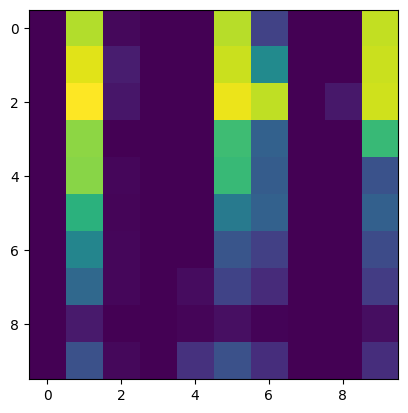

In [ ]:
plt.imshow(agent.Qtable.max(axis=2), )